# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ *liste des points auxquels on cherche à répondre*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
education = ['CCHGSC','CSUEXP','CATTSC','CSKIPSC','CGETBY','CHMWK','CINTSC','CWRKSC','UENG','UENGNEG','UENGPOS']
family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT']
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','GHEADS','KAPPMED','SSHELP']
programs_hh = ['MPUBHOUS']

In [4]:
# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh + programs_hh]


In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')
# replace all the missing values by the str 'no data', No by 0 and Yes by 1
child.replace([-7,-8,-9],-1,inplace=True) 

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,GHEADS,KAPPMED,SSHELP,CHLD0_5,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,MPUBHOUS
0,5561612801,1,5561612803,5561612800,F,3,15,WI,2,A1,...,2,-1,-1,2,0,3,1,4,1,-1
1,5470400001,2,5470400003,5470400000,M,14,15,WI,2,A1,...,-1,1,-1,0,2,3,2,2,2,-1
2,5787427204,2,5787427205,5787427200,F,9,15,WI,2,A1,...,-1,-1,-1,0,4,6,1,3,2,2
3,5410681601,1,5410681604,5410681600,M,4,15,WI,2,A1,...,2,-1,-1,3,0,5,1,2,2,2
4,5051721601,2,5051721605,5051721600,F,17,15,WI,2,A1,...,-1,-1,-1,0,4,5,1,4,2,1


In [6]:
# Divide child data in three dfs

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 61)
fc2: (10925, 61)
fc3:(11087, 61)
True


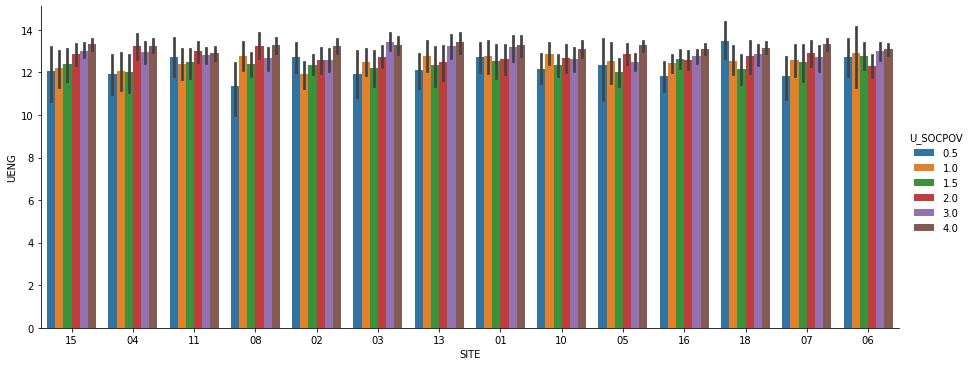

In [8]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc2, height=5, aspect=2.5)

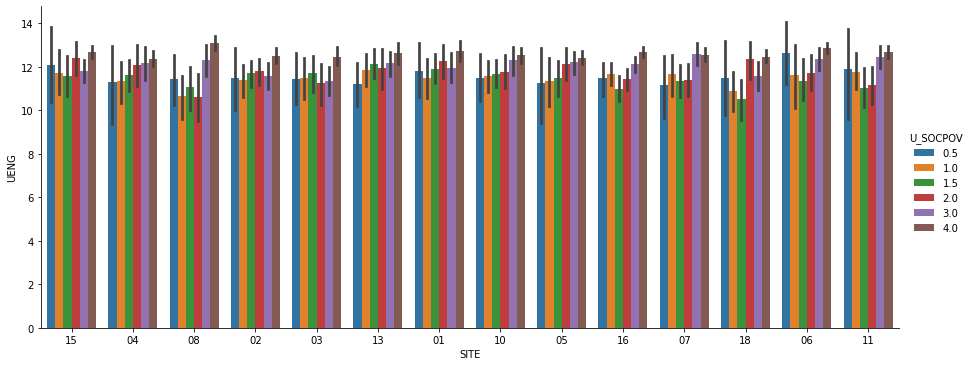

In [9]:
sns.catplot(x='SITE', y='UENG', hue='U_SOCPOV', kind='bar', data=fc3, height=5, aspect=2.5)

<AxesSubplot:xlabel='CSUEXP', ylabel='Density'>

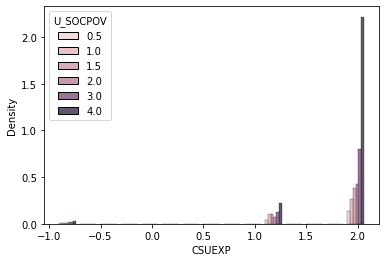

In [10]:
sns.histplot(x='CSUEXP', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='density', data=fc3)

<AxesSubplot:xlabel='CSKIPSC', ylabel='Density'>

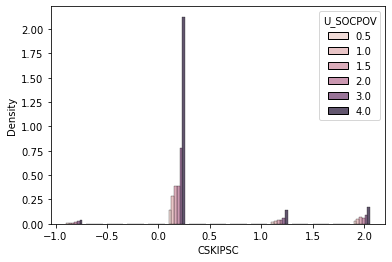

In [11]:
sns.histplot(x='CSKIPSC', hue='U_SOCPOV', multiple='dodge', shrink=.8, stat='density', data=fc3)

## Propensity score attempt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

outcome = 'UENGNEG'
predictors = ['KAPPMED','MPUBHOUS']
df_noNull = child.loc[(child[outcome] != -1) & (child[predictors] != -1)]
glm = sm.GLM(df_noNull[outcome].values, df_noNull[predictors].replace(2,0).values, family=sm.families.Poisson())
res = glm.fit()
res.summary()

reg = RandomForestRegressor()
X = df_noNull[predictors].replace(2,0).values.reshape(1,-1)
y = df_noNull[outcome].values.reshape(1,-1)
reg.fit(X, y)
reg.predict(X)-y #=array(0) si le RFR a marché


In [14]:
oh = ['KAPPMED','MPUBHOUS']
child[oh]

,KAPPMED,MPUBHOUS
0,-1,-1
1,1,-1
2,-1,2
3,-1,2
4,-1,1
...,...,...
34327,-1,1
34328,-1,-1
34329,-1,-1
34330,-1,-1


In [28]:
child.iloc[1][oh].values

array([1, -1], dtype=object)